[Reference](https://pub.towardsai.net/causal-inference-python-implementation-fa94c76cd5af)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import os

import warnings
warnings.filterwarnings("ignore")

!pip install pycausalimpact
from causalimpact import CausalImpact

# Loading the dataset

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/Branden-Kang/Python-practice/master/Data/sales-data-set.csv")
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [4]:
df['Store'] = df['Store'].astype('category')
df['Dept'] = df['Dept'].astype('string')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
print("Total number of stores:", df.Store.nunique())
print("Total number of departments:", df.Dept.nunique())

Total number of stores: 45
Total number of departments: 81


# Data Preparation

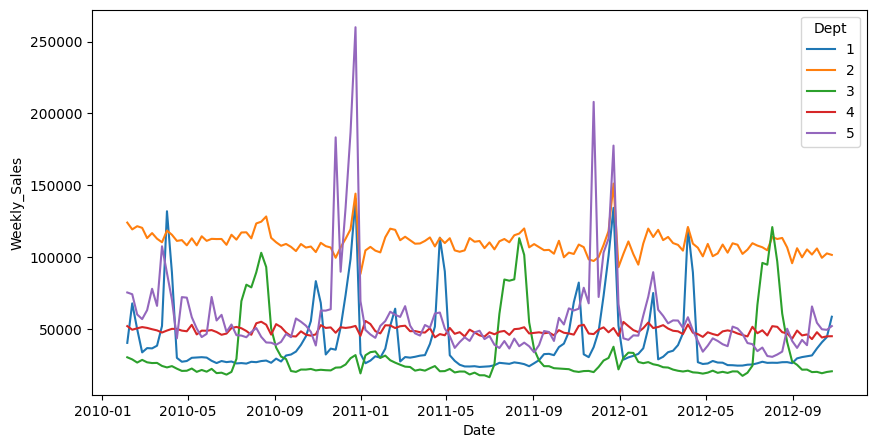

In [5]:
df_sales_new=df[(df['Store'] == 10) & (df['Dept'].isin(['1', '2', '3', '4','5' ]))].drop(columns=['IsHoliday'])
df_sales_new['Date'] = pd.to_datetime(df_sales_new['Date'])
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_sales_new, x='Date', y='Weekly_Sales',hue="Dept")
plt.show()

In [6]:
df_dept4_marketing=df_sales_new.copy()
df_dept4_marketing['Marketing_Campaign'] = np.where((df_dept4_marketing['Dept'] == '4') & (df_dept4_marketing['Date'] > "2012-06-30") &
    (df_dept4_marketing['Date'] < "2012-10-01"),'Active', 'Inactive')

In [7]:
print(df_dept4_marketing[
    (df_dept4_marketing['Date'] > "2012-06-01") &
    (df_dept4_marketing['Date'] < "2012-12-01") &
    ((df_dept4_marketing['Dept'] == '2') | (df_dept4_marketing['Dept'] == '4'))])

      Store Dept       Date  Weekly_Sales Marketing_Campaign
87789    10    2 2012-06-08     109543.37           Inactive
87790    10    2 2012-06-15     108530.26           Inactive
87791    10    2 2012-06-22     102144.47           Inactive
87792    10    2 2012-06-29     105107.69           Inactive
87793    10    2 2012-07-06     109596.98           Inactive
87794    10    2 2012-07-13     107945.92           Inactive
87795    10    2 2012-07-20     106771.51           Inactive
87796    10    2 2012-07-27     104651.11           Inactive
87797    10    2 2012-08-03     113930.50           Inactive
87798    10    2 2012-08-10     112523.39           Inactive
87799    10    2 2012-08-17     113259.20           Inactive
87800    10    2 2012-08-24     106630.07           Inactive
87801    10    2 2012-08-31      95671.50           Inactive
87802    10    2 2012-09-07     106094.76           Inactive
87803    10    2 2012-09-14      99757.84           Inactive
87804    10    2 2012-09

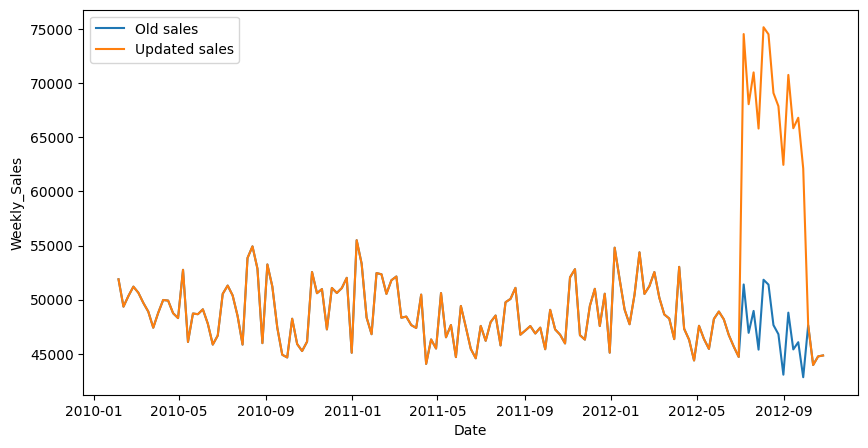

In [8]:
new_sales = df_dept4_marketing.copy()
new_sales['New_sales']=np.where(new_sales['Marketing_Campaign']=="Active",new_sales['Weekly_Sales'] * 1.45 ,new_sales['Weekly_Sales'])
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df_sales_new.query("Dept == '4'"),
    x="Date", y="Weekly_Sales",label='Old sales'
)
sns.lineplot(
    data=new_sales.query("Dept == '4'"),
    x="Date", y="New_sales",label='Updated sales'
)
plt.show()

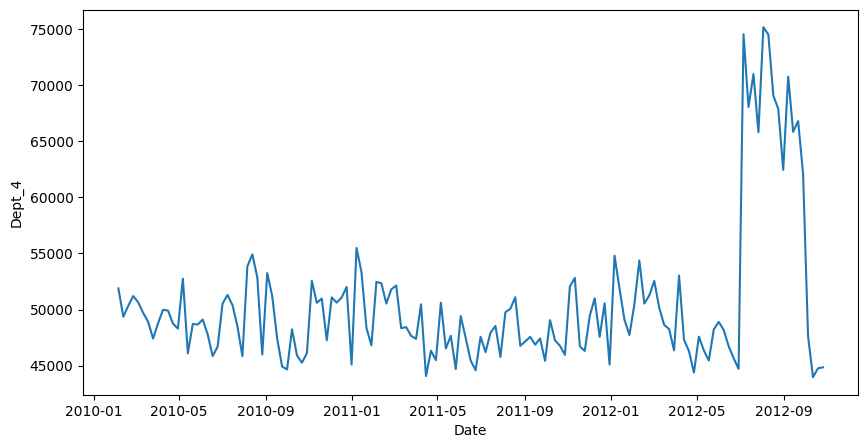

In [9]:
df_sales_causal=new_sales.pivot(index="Date", columns="Dept", values="New_sales")
df_sales_causal.columns=['Dept_1', 'Dept_2', 'Dept_3', 'Dept_4', 'Dept_5']
df_sales_causal=df_sales_causal.sort_values(by='Date')
df_final=df_sales_causal.drop(['Dept_1', 'Dept_2', 'Dept_3', 'Dept_5'],axis=1)
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_final,x="Date", y="Dept_4")
plt.show()

# Causal Analysis

In [10]:
marketing_pre_period=['2010-02-05','2012-06-29']
marketing_post_period=['2012-07-06','2012-10-26']
impact = CausalImpact(df_final, marketing_pre_period, marketing_post_period)
print(impact.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    63253.19           1075304.21
Prediction (s.d.)         48680.53 (680.69)  827569.08 (11571.67)
95% CI                    [47326.61, 49994.85][804552.39, 849912.52]

Absolute effect (s.d.)    14572.65 (680.69)  247735.13 (11571.67)
95% CI                    [13258.33, 15926.58][225391.69, 270751.82]

Relative effect (s.d.)    29.94% (1.4%)      29.94% (1.4%)
95% CI                    [27.24%, 32.72%]   [27.24%, 32.72%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [11]:
print(impact.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 63253.19. By contrast, in the absence of an
intervention, we would have expected an average response of 48680.53.
The 95% interval of this counterfactual prediction is [47326.61, 49994.85].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 14572.65 with a 95% interval of
[13258.33, 15926.58]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1075304.21.
By contrast, had the intervention not taken place, we would have expected
a sum of 827569.08. The 95% interval of this prediction is [804552.39, 849912.52].


The above results are given in terms of absolute numbers. In r